# Extracting Excitation Coefficients

The goal of this code is to import SXS data, limiting to spin $\Chi = 0.69 \pm 0.05$ or close to it, then fit the $l=2, m=2$ waveform to a damped sinusoid model. After fitting, the coefficients for up to overtone $N=7$ is extracting and stored.

In [1]:
# For downloading data
import sxs

# For interacting with the data
import h5py
import numpy as np
from matplotlib import pyplot as plt
import json
import pandas as pd

#Other libraries
from lmfit import Model, minimize, Parameters
import qnm

Obtain data from the SXS Catalog and then store BBH Mergers with spins close to $\chi = 0.69 \pm 0.5$. Then store the name of the simulation, the waveform, the spin, and the mass into their respective array for later use. The following code block will take around 9 min to load, even longer if you don't have the SXS simulations downloaded. 

#### NOTE: Be sure to have 50-70 gb available for downloading the rhOverM.h5 files as they are LARGE.

In [ ]:
#Initializing arrays that will be used for the fitting function
waveforms = []
names = []
spins = []
masses = []

#Loop through the entire SXS BBH catalog
for i in range(2300):
    #Catch exception block is here because I didnt want to check how many BBH simulations there are, I know its over 2265, so I put 2300.
    try:
        #Change the format of i from say, 1 to 0001 as the SXS BBH catalog has its files names in that format
        i = '{0:04}'.format(i)

        #Load the metadata to get the spin and mass information, spin is most important right now
        mtdt = sxs.load(f"SXS:BBH:{i}/Lev/metadata.json", download = False)
        spin = mtdt.remnant_dimensionless_spin[2]
        mass = mtdt.remnant_mass
        
        #Most of the BBHs with random spin orientations will converge to Chi = 0.69, which is what we're looking for to compare the overtone numbers.
        if 0.65 <= spin <= 0.75:
            #If the spin matches, then load the large waveform rhOVerM file, it will download if not already stored locally and each is about 80-100 mb
            #Store all the information of masses, spins, etc to the arrays
            names.append(i)
            spins.append(spin)
            masses.append(mass)
            w = sxs.load(f"SXS:BBH:{i}/Lev/rhOverM", extrapolation_order=2, download = False)
            waveforms.append([i,w])
    except:
        pass

We have to obtain the quasinormal modes. So first using the qnm library, we extract all the qnms for the desired spin by looping through all the NR Simulations and putting in the spin to obtain the QNM for the fundamental mode and the first 7 overtones

In [3]:
# Initialize an empty list to store the final result
all_omega = []

# Loop over all spins
for j in range(len(spins)):
    # Initialize an empty list to store the freq values for this spin
    omega = []
    
    # Loop over all overtones
    for i in range(8):
        # Calculate the grav_220 mode for this overtone
        grav_220 = qnm.modes_cache(s=-2,l=2,m=2,n=i)
        
        # Calculate the freq, A, and B values for this spin and overtone
        freq, A, B = grav_220(a=spins[j])
        
        # Append the freq value to the omega list
        omega.append(freq)
    
    # Append the omega list for this spin to the all_omega list
    all_omega.append(omega)

In [4]:
# Convert the all_omega list to a pandas DataFrame
qnmFreq_df = pd.DataFrame(all_omega, columns=[f'N={i}' for i in range(8)])
qnmFreq_df.insert(0, "Name", names)
qnmFreq_df.insert(1, "Spin", spins)
qnmFreq_df.insert(2, "Remnant Mass", masses)

In [5]:
qnmFreq_df

,Name,Spin,Remnant Mass,N=0,N=1,N=2,N=3,N=4,N=5,N=6,N=7
0,0001,0.686462,0.951609,0.526704-0.081288j,0.514860-0.245813j,0.492964-0.415136j,0.463866-0.588731j,0.432914-0.760352j,0.415548-0.927633j,0.414827-1.107500j,0.415936-1.301166j
1,0002,0.686448,0.951610,0.526698-0.081289j,0.514853-0.245815j,0.492957-0.415139j,0.463859-0.588736j,0.432906-0.760358j,0.415540-0.927643j,0.414818-1.107512j,0.415926-1.301179j
2,0003,0.691447,0.951083,0.528846-0.081110j,0.517150-0.245245j,0.495488-0.414097j,0.466582-0.587123j,0.435638-0.757964j,0.418439-0.924115j,0.418123-1.103112j,0.419441-1.296070j
3,0007,0.664091,0.955270,0.517478-0.082034j,0.504985-0.248199j,0.482071-0.419546j,0.452136-0.595644j,0.421057-0.770712j,0.402856-0.942781j,0.400411-1.126329j,0.400630-1.323009j
4,0008,0.664091,0.955267,0.517478-0.082034j,0.504985-0.248199j,0.482071-0.419546j,0.452136-0.595644j,0.421057-0.770713j,0.402855-0.942781j,0.400410-1.126329j,0.400630-1.323009j
...,...,...,...,...,...,...,...,...,...,...,...
590,2153,0.661903,0.966646,0.516608-0.082102j,0.504053-0.248420j,0.481042-0.419956j,0.451027-0.596295j,0.419928-0.771696j,0.401638-0.944209j,0.399032-1.128099j,0.399169-1.325061j
591,2154,0.670840,0.965718,0.520197-0.081818j,0.507897-0.247506j,0.485286-0.418257j,0.455599-0.593609j,0.424574-0.767646j,0.406637-0.938317j,0.404696-1.120791j,0.405178-1.316588j
592,2155,0.679580,0.964696,0.523800-0.081527j,0.511754-0.246574j,0.489540-0.416535j,0.460180-0.590909j,0.429205-0.763599j,0.411596-0.932401j,0.410328-1.113438j,0.411156-1.308058j
593,2156,0.695775,0.965339,0.530733-0.080951j,0.519166-0.244741j,0.497710-0.413176j,0.468973-0.585705j,0.438028-0.755868j,0.420966-0.921016j,0.421011-1.099241j,0.422512-1.291574j


In [6]:
# qnmFreq_df.to_csv("qnm_frequencies.csv", index=False)

In [7]:
only_wav = [row[1] for row in waveforms]

# The Fitting

A non-linear least-squares minimization is done on the waveform and fitted to $$h_{lm}^N(t) = d + \sum_{n=0}^N C_{lmn}e^{-i\omega_{lmn}(t-t_0)}$$ where $h_{lm}^N(t)$ will be the complex strain and $t$ is the time from the waveform in the NR simulation. The coefficients $C_{lmn}$ is what is going to be extracted from the fitting.

The function takes in the start time $T$ which tells how far after the peak strain time should the fitting start $t_0$, then it takes the waveform for the y values in the fitting, then the spin for calculating the qnm frequencies which after dividing after the next input, the mass, will provide the $\omega_{lmn}$. Once the fitting is done until $t_0 + 90M$ the lmfit parameters are returned.

In [8]:
def minWaveform(T, w, spin, mass):
    t_0 = w.max_norm_time() + T
    # Calculate omega array using a list comprehension
    omega = np.asarray([qnm.modes_cache(s=-2, l=2, m=2, n=i)(a=spin)[0] for i in range(8)])
    
    # Calculate dimensionless qnm frequency
    freq = omega / mass
    
    # Initialize Parameters object
    params = Parameters()
    
    # Add C and phi parameters for each overtone
    for i in range(len(freq)):
        params.add(f'C_{i}', value=0., vary=True)
        params.add(f'phi_{i}', value=0., vary=True)
    
    # Add const parameter
    params.add('const', value=0., vary=True)
    
    # Define h function
    def h(params, t):
        h_s = [params[f'C_{i}'].value * np.exp(-1j * (freq[i] * (t - t_0) + params[f'phi_{i}'].value)) for i in range(len(freq))]
        h_s.append(params['const'].value)
        return sum(h_s)

    # Define funcBoth function
    def funcBoth(params, t, data):
        N = len(t)
        t_real = t[N//2:]
        t_imag = t[:N//2]
        h_real = np.real(h(params, t_real))
        h_imag = np.imag(h(params, t_imag))
        return np.vstack([h_real, h_imag]) - np.vstack([data[:N//2], data[N//2:]])
    
    # Get ringdown waveform data
    i1 = w.index_closest_to(t_0)
    i2 = w.index_closest_to(w.max_norm_time() + 90.0)
    w_ringdown = w[i1:i2]
    w_2_2_ringdown = w_ringdown[:, w_ringdown.index(2, 2)]
    
    # Prepare data for minimization
    tdata = np.hstack([w_2_2_ringdown.t, w_2_2_ringdown.t])
    wdata = np.hstack([w_2_2_ringdown.data.real, w_2_2_ringdown.data.imag])
    
    # Perform minimization
    out = minimize(funcBoth, params, args=(tdata, wdata))
    
    return out

the following initializes the times after the peak strain waveform occurs. This is to test the fitting and see how the excitation coefficients vary after an x amount of time after the merger. This will allow to see how the source factors will be obtained at various start times and if they are time dependent or not. We can then get close to the peak strain time and see if linear perturbation theory is a good fit for that.

In [9]:
times_after = np.linspace(0,25,6)

Now to actually obtain the excitation coefficients $C_{lmn}^N$, the phase values $\phi$ and the constant $d$ at the end. I only fitted for the first 5 simulations but this can be done for all of them. BEWARE! this will take a LOT of time (20-30 seconds for each fit on my computer). So if I wanted to do this for all 595 simulations that are close to $\chi=0.69$ then it would take a little above 3-5 hours. Then if you wanted to change the start times from 0M to anything else, it would have to repeat again. I want to optimize this but am unsure how to make the minWaveform() function more efficient.

In [10]:
minimization_values = []

for i, name in enumerate(names[:5]):
    print(name)
    minimization_values.append(minWaveform(times_after[0], waveforms[i][1], spins[i], masses[i]))

0001
0002
0003
0007
0008


The minimization_values list only stored the minimizerResult of the fits, to actually extract the values, we need to iterate through the lmfit parameter values that were updated after the fitting.

In [11]:
param_values = []
for minimizer_result in minimization_values:
    values = [param.value for param in minimizer_result.params.values()]
    param_values.append(values)

The values printed out will be shown as $C_0$, $\phi_0$, $C_1$, $\phi_1$, ... $C_8$, $\phi_8$, and $d$. A total of 17 values in the list.

In [12]:
param_values[0]

[0.9507659091822734,
 -0.6690622375816772,
 -3.9228109447655495,
 -1.72120372037849,
 -11.387638679110603,
 0.9466352794638069,
 26.874528890793865,
 0.895424759729753,
 -45.01705744519322,
 1.065717858977951,
 -45.26917443609964,
 -1.855112213468027,
 -24.094928532850002,
 1.4828232179176455,
 -5.2951103617624815,
 4.73955974352272,
 0.0007970050248157826]

Now to extract the excitation coefficients themselves. They are the even values of the list from 0, 2, 4, ..., 16 while the phase $\phi$ values are the odd values not including the last value in the list as that is the shifting value $d$. The excitation coefficients $C_{lmn}^N$ are stored in the pure_amplitude list. The coefficients are also normalized to their highest value in the list so we can compare each NR simulation. The pure_amplitudes are too varying in their values for comparison so it is normalized to each excitation coefficients max value for each fit.

In [13]:
normalized_amplitudes = []
pure_amplitudes = []

for result_values in param_values:
    norm_amps = []
    pure_amps = []
    result_values = np.abs(result_values)
    for i in range(8):
        pure_amp = abs(result_values[2 * i])
        pure_amps.append(pure_amp)
        norm_amp = pure_amp / max(result_values)
        norm_amps.append(norm_amp)
    normalized_amplitudes.append(norm_amps)
    pure_amplitudes.append(pure_amps)

In [14]:
phases = []

for result_values in param_values:
    phase_vals = [result_values[2 * i + 1] for i in range(8)]
    phases.append(phase_vals)

To see how the excitation coefficients compare to one another, they are plotted as a function of overtone from $N=0$ being the fundamental mode and subsequent values for $N$ being the overtones up to $N=7$.

In [15]:
overtones = np.arange(0,8)

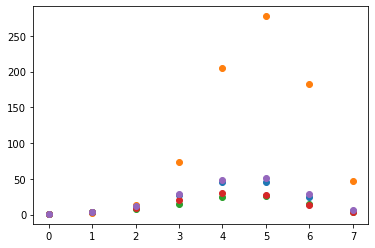

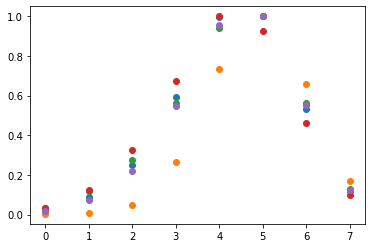

In [16]:
%matplotlib inline

for amplitudes in pure_amplitudes:
    plt.scatter(overtones, amplitudes)
plt.show()

for amplitudes in normalized_amplitudes:
    plt.scatter(overtones, amplitudes)
plt.show()

# Storing the data

The data is stored in separate files. 

In [22]:
pure_amplitudes

[[0.9507659091822734,
  3.9228109447655495,
  11.387638679110603,
  26.874528890793865,
  45.01705744519322,
  45.26917443609964,
  24.094928532850002,
  5.2951103617624815],
 [0.9834868613349507,
  2.2351569457094307,
  12.783467187973653,
  74.00142844822192,
  204.36979979367862,
  277.4676483844329,
  182.12463147559964,
  46.73411021607431],
 [0.8244123068668665,
  2.999894976040874,
  7.048650284111096,
  14.441364347817439,
  24.177297484251014,
  25.63904700256808,
  14.372873458747183,
  3.289629256306589],
 [0.926434053989134,
  3.7023598864313674,
  9.735429931341272,
  20.160696865985347,
  30.021996299542057,
  27.75958171727559,
  13.922973169944543,
  2.922313439556596],
 [0.9262376505311057,
  3.754800298422359,
  11.25872657649718,
  28.006409152626524,
  48.94381768456039,
  51.1585259321746,
  28.357088397800418,
  6.469240627095996]]

In [17]:
data = {'Name': names[:5], 'Spin': spins[:5], 'Remnant Mass': masses[:5]}
for i in range(8):
    data[f'N={i}'] = [amp[i] for amp in pure_amplitudes]
pure_amp_df = pd.DataFrame(data)

In [18]:
pure_amp_df

,Name,Spin,Remnant Mass,N=0,N=1,N=2,N=3,N=4,N=5,N=6,N=7
0,0001,0.686462,0.951609,0.950766,3.922811,11.387639,26.874529,45.017057,45.269174,24.094929,5.295110
1,0002,0.686448,0.951610,0.983487,2.235157,12.783467,74.001428,204.369800,277.467648,182.124631,46.734110
2,0003,0.691447,0.951083,0.824412,2.999895,7.048650,14.441364,24.177297,25.639047,14.372873,3.289629
3,0007,0.664091,0.955270,0.926434,3.702360,9.735430,20.160697,30.021996,27.759582,13.922973,2.922313
4,0008,0.664091,0.955267,0.926238,3.754800,11.258727,28.006409,48.943818,51.158526,28.357088,6.469241


In [19]:
# pure_amp_df.to_csv('Excitation_Coefficients.csv', index=False)

In [21]:
pure_amp_df

,Name,Spin,Remnant Mass,N=0,N=1,N=2,N=3,N=4,N=5,N=6,N=7
0,0001,0.686462,0.951609,0.950766,3.922811,11.387639,26.874529,45.017057,45.269174,24.094929,5.295110
1,0002,0.686448,0.951610,0.983487,2.235157,12.783467,74.001428,204.369800,277.467648,182.124631,46.734110
2,0003,0.691447,0.951083,0.824412,2.999895,7.048650,14.441364,24.177297,25.639047,14.372873,3.289629
3,0007,0.664091,0.955270,0.926434,3.702360,9.735430,20.160697,30.021996,27.759582,13.922973,2.922313
4,0008,0.664091,0.955267,0.926238,3.754800,11.258727,28.006409,48.943818,51.158526,28.357088,6.469241
